Using this tutorial: https://huggingface.co/blog/clipseg-zero-shot

In [5]:
from PIL import Image
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2

In [6]:
from transformers import CLIPSegProcessor, CLIPSegForImageSegmentation

processor = CLIPSegProcessor.from_pretrained("CIDAS/clipseg-rd64-refined")
model = CLIPSegForImageSegmentation.from_pretrained("CIDAS/clipseg-rd64-refined")

In [7]:
# def find_objects(image, prompts):
#     # image is a PIL image

#     # prepare clipseg model inputs
#     inputs = processor(text=prompts, images=[image] * len(prompts), padding="max_length", return_tensors="pt")
    
#     # predict
#     with torch.no_grad():
#         outputs = model(**inputs)
#         preds = outputs.logits.unsqueeze(1)

#     # get bounding boxes
#     output = {}
#     for i, prompt in enumerate(prompts):
#         output[prompt] = {}

#         sigmoid_logits_square = torch.sigmoid(preds[i][0]).numpy()
#         # resize to image size
#         sigmoid_logits = cv2.resize(sigmoid_logits_square, (image.width, image.height))
#         output[prompt]["sigmoid_logits"] = sigmoid_logits


#         # get bounding boxes - use this method: https://stackoverflow.com/questions/58419893/generating-bounding-boxes-from-heatmap-data
#         output[prompt]["bboxs"] = []

#         # blur the sigmoid logits for more reliable thresholding
#         blur = cv2.GaussianBlur(sigmoid_logits, (51,51), 0)

#         # threshold
#         thresholded = cv2.threshold((255*blur).astype("uint8"), 128, 255, cv2.THRESH_BINARY)[1]
#         # thresholded = cv2.threshold((255*sigmoid_logits).astype("uint8"), 128, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

#         # get contours
#         contours = cv2.findContours(thresholded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
#         contours = contours[0] if len(contours) == 2 else contours[1]
#         for c in contours:
#             output[prompt]["bboxs"].append(cv2.boundingRect(c)) # x,y,w,h
        
#     return output


# def display_prompt_results(prompt_results, logits_axis, bbox_axis, extent):
#     # prompt_results is a prompt-specific object, part of the object returned by the find_objects() function
#     # x_offset and y_offset are for how much to offset the logit heatmap / bboxes
#     # useful if the results are from a crop

#     print(extent)

#     sigmoid_logits = prompt_results["sigmoid_logits"]
#     h, w = sigmoid_logits.shape
#     logits_axis.imshow(sigmoid_logits, vmin=0, vmax=1, extent=extent)
    
#     for bbox in prompt_results["bboxs"]:
#         x,y,w,h = bbox
#         bbox_axis.add_patch(plt.Rectangle((x, y), w, h, edgecolor='red', facecolor=(0,0,0,0), lw=1))



# def process_image(image_path, prompts, nrows=1, ncols=1):    
#     with Image.open(image_path).convert("RGB") as image:
#         # resize so not humongous 
#         if image.width > 1024:
#             image = image.resize((1024, int(1024 * image.height / image.width)))

#         # set up figure
#         _, ax = plt.subplots(2, len(prompts) + 1, figsize=(6*(len(prompts) + 1), 8))
#         [a.axis('off') for a in ax.flatten()]
#         ax[0][0].imshow(image)
#         for i, prompt in enumerate(prompts):
#             # prompt title
#             ax[0][i+1].text(0, -15, prompt)
#             # background image
#             ax[1][i+1].imshow(image, alpha=0.75)
        
#         # generate and display results for each crop
#         crop_width = int(image.width / ncols)
#         crop_height = int(image.height / nrows)
#         for r in range(nrows):
#             for c in range(ncols):
#                 print(f"row {r} col {c}")
#                 x = c * crop_width
#                 y = r * crop_height
#                 crop = image.crop((x, y, x + crop_width, y + crop_height))

#                 results = find_objects(crop, prompts)
#                 for i, prompt in enumerate(prompts):
#                     extent = (x, y, x + crop_width, y + crop_height)
#                     display_prompt_results(results[prompt], ax[0][i+1], ax[1][i+1], extent)



# directory_path = R"G:\.shortcut-targets-by-id\1BCCfXZq98f4rFOF8m0AweybL4qQakAUB\Summer Dive 2022\Monteverde Imagery - Stephanie\River\Dry Flight\100MEDIA"
# image_basename = "P1480443.JPG"  # two red fruits
# # image_basename = "P2120507.JPG"  # big bush with fruits
# # image_basename = "P0960390.JPG"  # ferns, no flowers
# # image_basename = "P1090403.JPG"  # palm tree with cool fruits, no flowers
# # image_basename = "P1580453.JPG"  # log with fungus
# # image_basename = "P2330528.JPG"  # flowers on bush, and sky
# # image_basename = "P0800374.JPG"  # vine with tiny yellow flowers
# # image_basename = "P1280422.JPG"  # bush with colorful leaves
# # image_basename = "P1250419.JPG"  # tree trunk, bush w colorful leaves
# # image_basename = "P2110506.JPG"  # canopy tree with lots of pale pink fruits


# # directory_path = R"C:\Users\duker\Documents\id_from_image\clip_test_images"
# # image_basename = "orange_maple.JPG"


# image_path = os.path.join(directory_path, image_basename)

# process_image(image_path, ["flower", "leaf", "botanical fruit"], nrows=2, ncols=2)

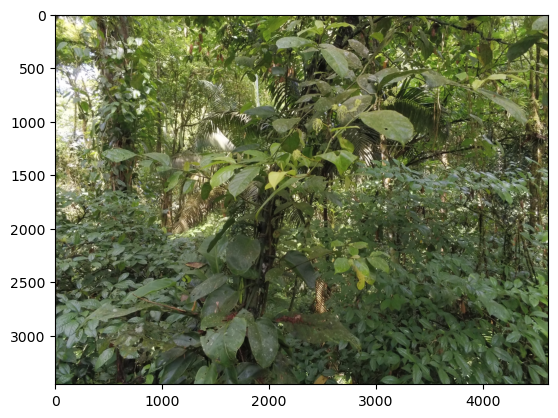

row 0 col 0


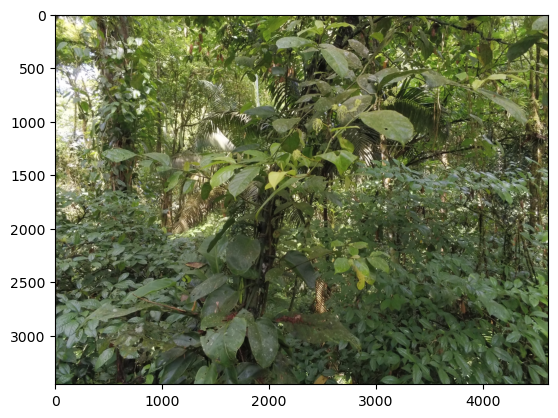

Unused or unrecognized kwargs: padding.


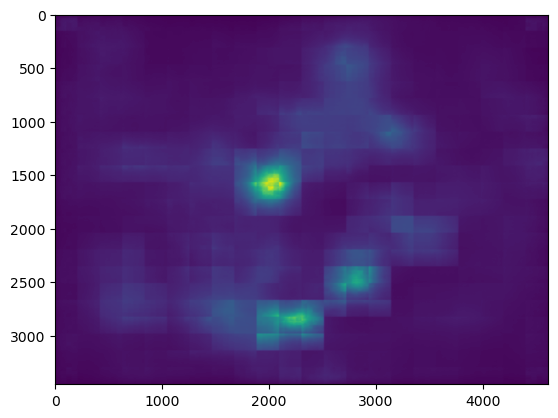

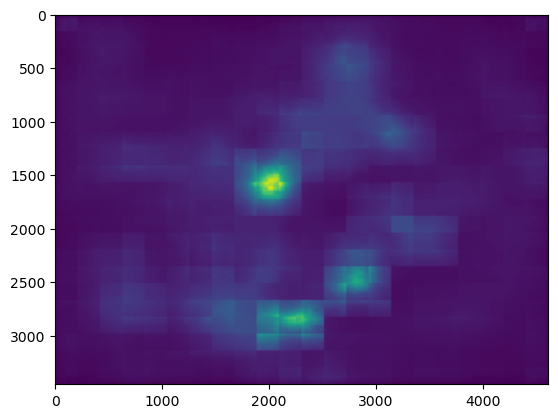

In [28]:
def get_sigmoid_logit_map(image, prompts):
    # image is a PIL image

    # prepare clipseg model inputs
    inputs = processor(text=prompts, images=[image] * len(prompts), padding="max_length", return_tensors="pt")
    
    # predict
    with torch.no_grad():
        outputs = model(**inputs)
        preds = outputs.logits.unsqueeze(1)

    # get sigmoid logits map for each prompt (resized to original image size)
    output = {}
    for i, prompt in enumerate(prompts):
        sigmoid_logits_square = torch.sigmoid(preds[i][0]).numpy()
        # resize to image size
        sigmoid_logits = cv2.resize(sigmoid_logits_square, (image.width, image.height))
        output[prompt] = sigmoid_logits

    return output


def get_bounding_boxes(heatmap):
    # heatmap should range from 0 to 1
    assert np.min(heatmap) >= 0 and np.max(heatmap) <= 1, "Heatmap values should range from 0 to 1"

    # based on this method: https://stackoverflow.com/questions/58419893/generating-bounding-boxes-from-heatmap-data

    # blur the sigmoid logits for more reliable thresholding
    blur = cv2.GaussianBlur(heatmap, (51,51), 0)

    # threshold
    thresholded = cv2.threshold((255*blur).astype("uint8"), 128, 255, cv2.THRESH_BINARY)[1]
    # thresholded = cv2.threshold((255*sigmoid_logits).astype("uint8"), 128, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

    # get contours / bounding boxes
    bboxs = []
    contours = cv2.findContours(thresholded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = contours[0] if len(contours) == 2 else contours[1]
    for c in contours:
        bboxs.append(cv2.boundingRect(c)) # x,y,w,h
    
    return bboxs


def process_image(image_path, prompts, nrows=1, ncols=1, crop_overlap_fraction=0.1):
    with Image.open(image_path).convert("RGB") as image:
        # resize so not humongous
        # if image.width > 1024:
        #     image = image.resize((1024, int(1024 * image.height / image.width)))
        
        plt.imshow(np.array(image))
        plt.show()

        # # set up figure
        # _, ax = plt.subplots(2, len(prompts) + 1, figsize=(6*(len(prompts) + 1), 8))
        # [a.axis('off') for a in ax.flatten()]
        # ax[0][0].imshow(image)
        # for i, prompt in enumerate(prompts):
        #     # prompt title
        #     ax[0][i+1].text(0, -15, prompt)
        #     # background image
        #     ax[1][i+1].imshow(image, alpha=0.75)
        
        # get sigmoid logits for all crops
        sigmoid_logits_dict = {}
        for p in prompts:
            sigmoid_logits_dict[p] = np.full((image.height, image.width), 0.)  # 0. so that dtype is float

        # calculate crop width and height, taking overlap into account
        # total width = ncols * crop width - (ncols-1) * crop overlap amount
        # total width = ncols * crop width - (ncols-1) * crop width * crop_overlap_fraction
        # total width = crop width (ncols - (ncols-1) * crop overlap fraction)
        crop_width = int(image.width / (ncols - (ncols-1)*crop_overlap_fraction))
        crop_height = int(image.height / (nrows - (nrows-1)*crop_overlap_fraction))

        for r in range(nrows):
            for c in range(ncols):
                print(f"row {r} col {c}")
                x = int(c * crop_width * (1 - crop_overlap_fraction))
                y = int(r * crop_height * (1 - crop_overlap_fraction))
                crop = image.crop((x, y, x + crop_width, y + crop_height))
                plt.imshow(np.array(crop))
                plt.show()

                crop_sigmoid_logits_dict = get_sigmoid_logit_map(crop, prompts)

                plt.imshow(crop_sigmoid_logits_dict["flower"])
                plt.show()
                
                # merge into main sigmoid logits map using element wise maximum
                for prompt in crop_sigmoid_logits_dict:
                    existing = sigmoid_logits_dict[prompt][y:y+crop_height,x:x+crop_width]
                    sigmoid_logits_dict[prompt][y:y+crop_height,x:x+crop_width] = np.maximum(existing, crop_sigmoid_logits_dict[prompt])
        
        plt.imshow(sigmoid_logits_dict["flower"])


directory_path = R"G:\.shortcut-targets-by-id\1BCCfXZq98f4rFOF8m0AweybL4qQakAUB\Summer Dive 2022\Monteverde Imagery - Stephanie\River\Dry Flight\100MEDIA"
image_basename = "P1480443.JPG"  # two red fruits
# image_basename = "P2120507.JPG"  # big bush with fruits
# image_basename = "P0960390.JPG"  # ferns, no flowers
# image_basename = "P1090403.JPG"  # palm tree with cool fruits, no flowers
# image_basename = "P1580453.JPG"  # log with fungus
# image_basename = "P2330528.JPG"  # flowers on bush, and sky
image_basename = "P0800374.JPG"  # vine with tiny yellow flowers
# image_basename = "P1280422.JPG"  # bush with colorful leaves
# image_basename = "P1250419.JPG"  # tree trunk, bush w colorful leaves
# image_basename = "P2110506.JPG"  # canopy tree with lots of pale pink fruits


# directory_path = R"C:\Users\duker\Documents\id_from_image\clip_test_images"
# image_basename = "P0800374.JPG"


image_path = os.path.join(directory_path, image_basename)

process_image(image_path, ["flower", "leaf", "botanical fruit"], nrows=1, ncols=1)